# Analysis of Proposed Amendments to the U.S. Constitution

**Objective:** This notebook analyzes the entire history of proposed amendments to the U.S. Constitution, from 1787 to 2014. The goal is to uncover historical trends, identify dominant themes in different eras, and understand the political and social contexts that drive the desire for constitutional change.

**Methodology:** The analysis will employ Natural Language Processing (NLP) to parse the text of the amendments and statistical modeling to explore the factors influencing their frequency.

In [124]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from collections import Counter
import spacy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

The dataset that will be used is all the [Proposed Amendments to the United States Constitution](https://www.archives.gov/open/dataset-amendments); the dataset uses a unique encoding which is why it isn't UTF8

In [125]:
data = pd.read_csv('all_proposed_amendments.csv', encoding='ISO-8859-1')

# Pre-processing
data = data[data['year'] != 19931.0]  # Remove the random 19931 year
data['title_or_description_from_source'] = data['title_or_description_from_source'].astype(str)

### Data Cleaning

There are some columns that contain very few unique values or are simply metadata that isn't useful for this analysis. The `source_code`, `date_approximation`, and `last_modified` columns, along with the `identifier` column (which serves as an index), will be dropped to streamline the dataset.

In [127]:
data.drop(columns=['identifier', 'source_code', 'date_approximation', 'last_modified'], inplace=True)

### Getting Rid of Duplicates For a New Dataset

The raw dataset contains numerous duplicate entries for the same proposed amendment. This occurs because an amendment is recorded at multiple stages of the legislative process. To ensure each unique amendment idea is counted only once, we will:
1.  **Tokenize** the amendment titles to create a consistent representation of each proposal.
2.  Remove duplicates based on these tokens, keeping only the **last recorded entry** for each unique amendment. This is based on the assumption that the final entry represents the most complete record.

In [128]:
# Tokenize the title_or_description_from_source column
data['title_tokens'] = data['title_or_description_from_source'].apply(
	lambda x: nltk.word_tokenize(x.lower()) if isinstance(x, str) else []
)

# Drop the duplicates within the 'title_tokens" column
data_unique = data.copy().drop_duplicates(subset='title_tokens', keep='last')

'''
To make a new csv file with the unique words:
data_unique.to_csv('all_proposed_amendments_cleaned.csv', index=False)
'''

print(data.shape)
print(data_unique.shape)
print(f'Dropped {data.shape[0] - data_unique.shape[0]} duplicate entries based on title_tokens.')
data_unique.head()

(11796, 14)
(4627, 14)
Dropped 7169 duplicate entries based on title_tokens.


,source_citation,source_index_number,title_or_description_from_source,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,title_tokens
7,"Ames, Herman V. The Proposed Amendments to the...",8,Trial by jury in civil action,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, action]"
20,"Ames, Herman V. The Proposed Amendments to the...",21,Trial by jury in civil cases,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, cases]"
23,"Ames, Herman V. The Proposed Amendments to the...",24,Religion,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[religion]
29,"Ames, Herman V. The Proposed Amendments to the...",30,Publication of journals annually,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[publication, of, journals, annually]"
34,"Ames, Herman V. The Proposed Amendments to the...",35,Period of enlistment of soldiers limited,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[period, of, enlistment, of, soldiers, limited]"


### Text Analysis Through NLP

To understand the core ideas within the proposals, we will perform several NLP steps on the amendment descriptions.

* **Preprocessing:** The text is converted to lowercase, and common "stop words" (e.g., 'the', 'a', 'in') are removed to focus on meaningful terms.
* **Lemmatization:** Words are reduced to their root form (e.g., "elections" becomes "election") using `spaCy`. This helps in accurately counting the frequency of a core concept regardless of its grammatical form.
* **Frequency Analysis:** We will count the occurrences of each lemma to identify the most common words and themes across all proposed amendments.

In [129]:
def preprocess_text_list(data):
    processed_list = []
    for text in data:
        # Tokenize into sentences
        tokens = word_tokenize(str(text).lower())
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        processed_list.append(" ".join(tokens))
    return processed_list
processed_texts = preprocess_text_list(data["title_or_description_from_source"])
print(processed_texts[:10])

['reservation nondelegated powers', 'apportionment representatives', 'restriction federal control election senators representatives', 'restriction upon levying direct taxes', 'commercial monopolies prohibited', 'indictment grand jury', 'jurisdiction federal courts', 'trial jury civil action', 'titles nobility', 'restriction federal control election senators representatives']


In [130]:
wordsplit = [word for processed_texts in processed_texts for word in processed_texts.split()]
print(wordsplit[:30])

['reservation', 'nondelegated', 'powers', 'apportionment', 'representatives', 'restriction', 'federal', 'control', 'election', 'senators', 'representatives', 'restriction', 'upon', 'levying', 'direct', 'taxes', 'commercial', 'monopolies', 'prohibited', 'indictment', 'grand', 'jury', 'jurisdiction', 'federal', 'courts', 'trial', 'jury', 'civil', 'action', 'titles']


In [131]:
freq2 = Counter(wordsplit)
freq2.most_common(15)

[('president', 2640),
 ('states', 2341),
 ('united', 1839),
 ('amendment', 1484),
 ('congress', 1417),
 ('constitution', 1379),
 ('rights', 1334),
 ('election', 1279),
 ('equal', 1183),
 ('vice', 1175),
 ('proposing', 1144),
 ('public', 873),
 ('representatives', 855),
 ('vote', 762),
 ('right', 758)]

In [132]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])
doc = nlp(" ".join(wordsplit))

In [133]:
nlp = spacy.load("en_core_web_sm")
lemmas = [token.lemma_ for token in doc]
print(lemmas[:30])

['reservation', 'nondelegate', 'power', 'apportionment', 'representative', 'restriction', 'federal', 'control', 'election', 'senator', 'representative', 'restriction', 'upon', 'levy', 'direct', 'taxis', 'commercial', 'monopoly', 'prohibit', 'indictment', 'grand', 'jury', 'jurisdiction', 'federal', 'court', 'trial', 'jury', 'civil', 'action', 'title']


In [134]:
freq3 = Counter(lemmas)
freq3.most_common(15)

[('president', 2648),
 ('right', 2090),
 ('states', 1871),
 ('united', 1832),
 ('amendment', 1608),
 ('election', 1417),
 ('congress', 1417),
 ('constitution', 1379),
 ('propose', 1231),
 ('equal', 1183),
 ('vice', 1175),
 ('term', 1157),
 ('state', 1114),
 ('provide', 1039),
 ('public', 873)]

In [135]:
freq3 = pd.DataFrame(freq3.most_common(50), columns=['word', 'frequency'])
freq3

,word,frequency
0,president,2648
1,right,2090
2,states,1871
3,united,1832
4,amendment,1608
5,election,1417
6,congress,1417
7,constitution,1379
8,propose,1231
9,equal,1183


In [136]:
def most_common_year_from_df(word):
    # Filter rows where the word appears in the text
    mask = data['title_or_description_from_source'].str.lower().str.contains(r'\b{}\b'.format(word), na=False)
    years = data.loc[mask, 'year']
    if not years.empty:
        return years.value_counts().idxmax()
    return None

freq3["Year mostly appear"] = freq3["word"].apply(most_common_year_from_df)
freq3

,word,frequency,Year mostly appear
0,president,2648,1969.0
1,right,2090,1969.0
2,states,1871,1993.0
3,united,1832,1993.0
4,amendment,1608,1993.0
5,election,1417,1969.0
6,congress,1417,1923.0
7,constitution,1379,1993.0
8,propose,1231,1861.0
9,equal,1183,1969.0


In [137]:
number_documents = len(data)
print(number_documents)

11796


In [138]:
number_of_documents_with_document = sum(1 for doc in processed_texts if 'president' in word_tokenize(doc))
print("Number of documents with the word president:", number_of_documents_with_document)

Number of documents with the word president: 1479


In [139]:
idf = number_documents/number_of_documents_with_document
print("Inverse Document Frequency for 'president':", idf)

Inverse Document Frequency for 'president': 7.975659229208925


In [140]:
tf = [word_tokenize(doc).count('president') for doc in processed_texts]
print(tf[:120])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [141]:
tf_idf = []
for i, doc in enumerate(processed_texts):
    tf_i = word_tokenize(doc).count('president')
    doc_length = len(word_tokenize(doc))
    if doc_length > 0:
        tf_normalized = tf_i / doc_length
    else:
        tf_normalized = 0
    tfidf_value = tf_normalized * idf
    tf_idf.append(tfidf_value)
    print(f"President {i}: TF = {tf_i}, Doc Length = {doc_length}, TF_norm = {tf_normalized:.2f}, IDF = {idf:.2f}, TF-IDF = {tfidf_value:.4f}")
    if (i >= 30):
        break

President 0: TF = 0, Doc Length = 3, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 1: TF = 0, Doc Length = 2, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 2: TF = 0, Doc Length = 6, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 3: TF = 0, Doc Length = 5, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 4: TF = 0, Doc Length = 3, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 5: TF = 0, Doc Length = 3, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 6: TF = 0, Doc Length = 3, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 7: TF = 0, Doc Length = 4, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 8: TF = 0, Doc Length = 2, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 9: TF = 0, Doc Length = 6, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 10: TF = 0, Doc Length = 3, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 11: TF = 0, Doc Length = 5, TF_norm = 0.00, IDF = 7.98, TF-IDF = 0.0000
President 12: TF = 0, Doc 

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
stop = stopwords.words('english')
tfidfvec = TfidfVectorizer(min_df=2,lowercase=True,stop_words=stop)
# min_df=2 means we only consider words that appear in at least 2 documents

tfidf_bow = tfidfvec.fit_transform(processed_texts)
#print(tfidf_bow.toarray())
print(tfidf_bow.shape)

(11796, 1637)


In [143]:
#It worked without using the ', index=processed_texts.index' at the end.
tfidf = pd.DataFrame(tfidf_bow.toarray(), columns=tfidfvec.get_feature_names_out())
tfidf.head(5)

,abode,abolish,abolished,abolishes,abolishing,abolishment,abolition,abortion,abortions,abridge,...,work,world,would,writing,writs,xi,xiv,year,years,yeas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
tfidf.max().sort_values(ascending=False).head(50)

used              1.000000
requisitions      1.000000
reconstruction    1.000000
religion          1.000000
amendment         1.000000
shall             1.000000
ratification      1.000000
prohibited        1.000000
right             1.000000
suffrage          1.000000
special           1.000000
liberty           1.000000
nan               1.000000
oath              1.000000
power             1.000000
prevention        1.000000
departments       1.000000
choice            1.000000
abolish           1.000000
abolished         1.000000
impeachment       1.000000
franchise         1.000000
balancing         1.000000
internal          1.000000
jurisdiction      1.000000
judges            1.000000
initiative        1.000000
busing            1.000000
citizenship       1.000000
clause            1.000000
compensation      1.000000
pres              0.950663
farmers           0.945790
adjournment       0.943226
equality          0.938293
repeals           0.938003
indians           0.937518
s

In [145]:
print(type(wordsplit))
text_set = set(wordsplit)
print(text_set.__len__())

<class 'list'>
2355


In [146]:
data_unique.head()

,source_citation,source_index_number,title_or_description_from_source,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,title_tokens
7,"Ames, Herman V. The Proposed Amendments to the...",8,Trial by jury in civil action,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, action]"
20,"Ames, Herman V. The Proposed Amendments to the...",21,Trial by jury in civil cases,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, cases]"
23,"Ames, Herman V. The Proposed Amendments to the...",24,Religion,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[religion]
29,"Ames, Herman V. The Proposed Amendments to the...",30,Publication of journals annually,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[publication, of, journals, annually]"
34,"Ames, Herman V. The Proposed Amendments to the...",35,Period of enlistment of soldiers limited,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[period, of, enlistment, of, soldiers, limited]"


<h1> Prediction: Number of Amendment Proposal w/ factors like Decades, Politcal Party in Power at the time, and whether the country was in war

In [147]:
data_unique['decades'] = (data_unique['year'] // 10) * 10
data_unique.head()

,source_citation,source_index_number,title_or_description_from_source,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,title_tokens,decades
7,"Ames, Herman V. The Proposed Amendments to the...",8,Trial by jury in civil action,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, action]",1780.0
20,"Ames, Herman V. The Proposed Amendments to the...",21,Trial by jury in civil cases,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, cases]",1780.0
23,"Ames, Herman V. The Proposed Amendments to the...",24,Religion,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[religion],1780.0
29,"Ames, Herman V. The Proposed Amendments to the...",30,Publication of journals annually,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[publication, of, journals, annually]",1780.0
34,"Ames, Herman V. The Proposed Amendments to the...",35,Period of enlistment of soldiers limited,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[period, of, enlistment, of, soldiers, limited]",1780.0


In [148]:
counts_df = data_unique.groupby('decades').count()
counts_df = counts_df.reset_index()
counts_df

,decades,source_citation,source_index_number,title_or_description_from_source,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,title_tokens
0,1780.0,173,174,174,174,84,84,3,3,0,0,31,28,0,174
1,1790.0,20,20,20,20,14,14,11,11,0,0,4,3,0,20
2,1800.0,37,37,37,37,27,27,26,26,0,0,22,22,0,37
3,1810.0,40,40,40,40,18,18,17,17,0,0,17,14,0,40
4,1820.0,75,76,76,76,62,62,55,55,0,0,57,55,0,76
5,1830.0,80,81,81,81,39,39,39,39,0,0,35,31,0,81
6,1840.0,44,44,44,44,39,39,38,38,0,0,38,38,0,44
7,1850.0,15,15,15,15,12,12,12,12,0,0,12,12,0,15
8,1860.0,409,409,409,409,196,196,191,191,0,0,192,182,5,409
9,1870.0,138,138,138,138,122,122,122,122,0,0,122,118,104,138


In [149]:
# create new df with only necessary columns we will be using
decades_df = pd.DataFrame({
    'decades' : counts_df['decades'],
    'proposal_counts' : counts_df['title_or_description_from_source']
    
})
decades_df

,decades,proposal_counts
0,1780.0,174
1,1790.0,20
2,1800.0,37
3,1810.0,40
4,1820.0,76
5,1830.0,81
6,1840.0,44
7,1850.0,15
8,1860.0,409
9,1870.0,138


In [150]:
# create new dataset for external information on war & political power
political_power = pd.read_excel('pol_power.xlsx')
political_power['decades'] = political_power['decades'].astype(float)
political_power.head()

,decades,in war?,"politcal party in power (democratic, republican, neither, or both)"
0,1780.0,1,neither
1,1790.0,1,neither
2,1800.0,1,both
3,1810.0,1,both
4,1820.0,0,both


In [151]:
# add new info into our existing df
decades_df['in_war'] = political_power['in war?']
decades_df['politcal_power'] = political_power['politcal party in power (democratic, republican, neither, or both)']
decades_df

,decades,proposal_counts,in_war,politcal_power
0,1780.0,174,1,neither
1,1790.0,20,1,neither
2,1800.0,37,1,both
3,1810.0,40,1,both
4,1820.0,76,0,both
5,1830.0,81,1,democratic
6,1840.0,44,1,democratic
7,1850.0,15,1,democratic
8,1860.0,409,1,republican
9,1870.0,138,1,republican


In [152]:
# one hot encode politcal party for modeling
df_encoded = pd.get_dummies(decades_df, columns=['politcal_power'])
df_encoded = df_encoded.drop(['politcal_power_both'], axis = 1) # to avoid multicollinearity
df_encoded

,decades,proposal_counts,in_war,politcal_power_democratic,politcal_power_neither,politcal_power_republican
0,1780.0,174,1,False,True,False
1,1790.0,20,1,False,True,False
2,1800.0,37,1,False,False,False
3,1810.0,40,1,False,False,False
4,1820.0,76,0,False,False,False
5,1830.0,81,1,True,False,False
6,1840.0,44,1,True,False,False
7,1850.0,15,1,True,False,False
8,1860.0,409,1,False,False,True
9,1870.0,138,1,False,False,True


In [153]:
X = df_encoded.drop(columns=['proposal_counts', 'decades'])  # predictors
y = df_encoded['proposal_counts'] # target

In [154]:
model = LinearRegression()
model.fit(X, y)

# View coefficients
coefficients = pd.Series(model.coef_, index=X.columns)
print("Intercept:", model.intercept_)
print("Coefficients:")
print(coefficients)

Intercept: 187.95419847328253
Coefficients:
in_war                      -52.938931
politcal_power_democratic    60.547074
politcal_power_neither      -38.015267
politcal_power_republican    72.560645
dtype: float64


In [155]:
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 16016.601286400904
R-squared: 0.10817386495173364


In [156]:
import numpy as np
avg_prop_count = df_encoded['proposal_counts'].mean()
RMSE = np.sqrt(mse)

print(avg_prop_count, RMSE)

192.79166666666666 126.5567117398398


In [157]:
relative_error = RMSE/avg_prop_count
print(relative_error)

0.6564428531999471


In [158]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.glm(formula='proposal_counts ~ in_war + politcal_power_democratic + politcal_power_neither + politcal_power_republican',
                data=df_encoded, family=sm.families.Poisson()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        proposal_counts   No. Observations:                   24
Model:                            GLM   Df Residuals:                       19
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1147.0
Date:                Tue, 01 Jul 2025   Deviance:                       2132.1
Time:                        20:18:03   Pearson chi2:                 2.17e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [159]:
democrat = np.exp(0.3104)
neither = np.exp(-0.4041)
republican = np.exp(0.3563)
war = np.exp(-0.2346)

print(democrat, neither, republican, war)

1.3639705932663844 0.6675773601949113 1.4280358947770884 0.7908871412226887


Given the Poisson Regression summary, we can conclude the following:
1. proposal count is 36% higher in democratic eras compared to when both parties are in power
2. proposal count is 33% lower when neither parties are in power
3. proposal counts is 43% higher in republican eras compared to when both parties are in power
4. during war periods, proposal counts are 21% lower on average

all of the coefficients have very low p-values (P>|z| = 0.000), meaning they’re statistically significant at any standard threshold (0.05, 0.01, etc). this means that we can rely on the interpretations above to make a prediction on amendment proposal counts based on politcal party in power and war status of the country at the time.

In [160]:
yearly_counts = data.groupby('year').size().reset_index(name='count').sort_values(by='year')
yearly_counts.head()

,year,count
0,1788.0,123
1,1789.0,188
2,1790.0,1
3,1791.0,1
4,1793.0,11


# Visualizations

c:\Users\alons\miniconda3\envs\dighum101\Lib\site-packages\matplotlib\text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


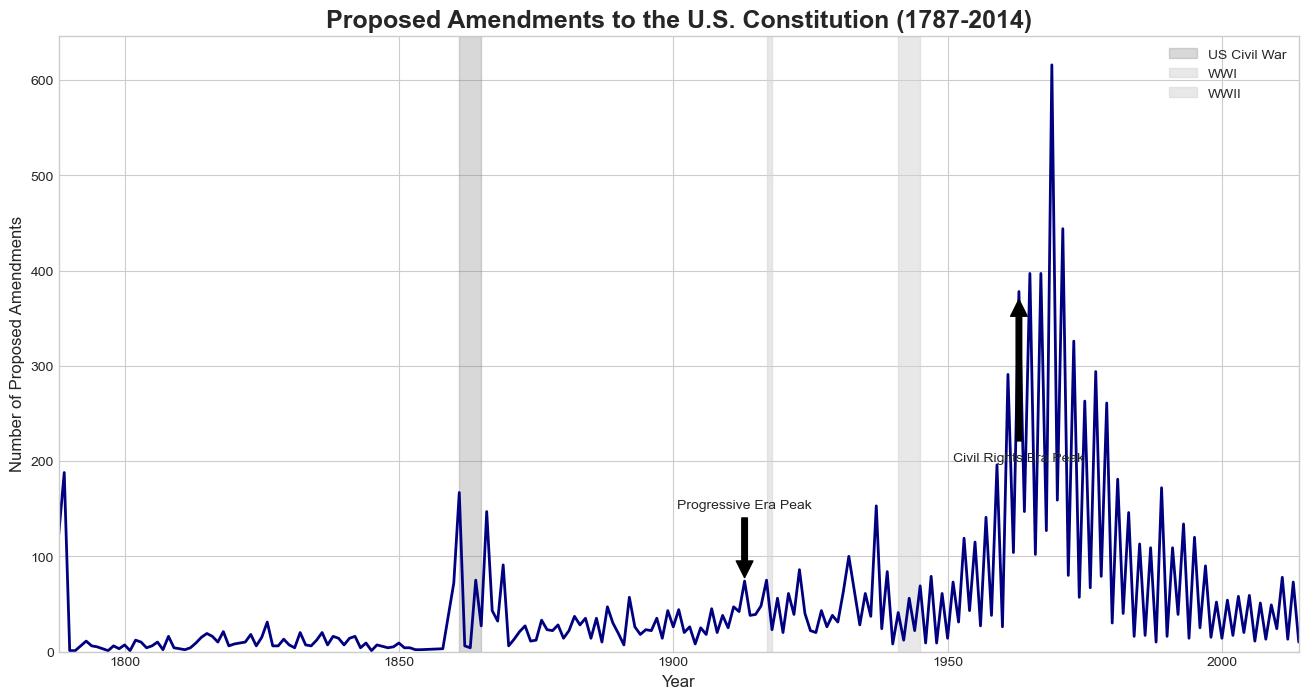

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style and size
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the data
ax.plot(yearly_counts['year'], yearly_counts['count'], color='navy', linewidth=2)

# Shading for major US wars
ax.axvspan(1861, 1865, color='gray', alpha=0.3, label='US Civil War')
ax.axvspan(1917, 1918, color='lightgray', alpha=0.5, label='WWI')
ax.axvspan(1941, 1945, color='lightgray', alpha=0.5, label='WWII')

# Annotations
ax.annotate('Progressive Era Peak', xy=(1913, yearly_counts.loc[yearly_counts['year'] == 1913, 'count']),
            xytext=(1913, 150), arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', fontsize=10)

ax.annotate('Civil Rights Era Peak', xy=(1963, yearly_counts.loc[yearly_counts['year'] == 1963, 'count']),
            xytext=(1963, 200), arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', fontsize=10)

# --- Final Touches ---
ax.set_title('Proposed Amendments to the U.S. Constitution (1787-2014)', fontsize=18, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Proposed Amendments', fontsize=12)
ax.set_xlim(yearly_counts['year'].min(), yearly_counts['year'].max())
ax.set_ylim(0)
ax.legend()

plt.show()

Figure shows the number of amendments proposed each year and significant events that could have influenced them

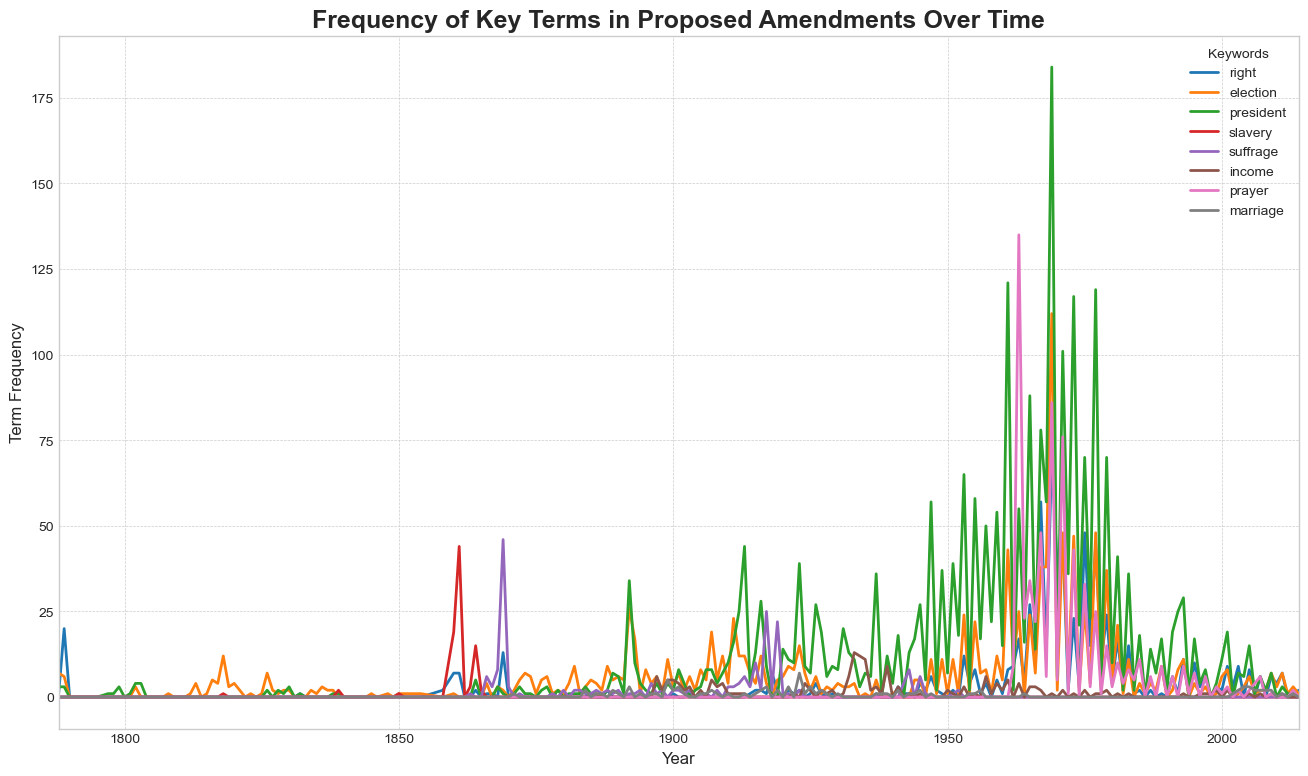

In [162]:
data['title_or_description_from_source'] = data['title_or_description_from_source'].astype(str)

keywords = ['right', 'election', 'president', 'slavery', 'suffrage', 'income', 'prayer', 'marriage']
keyword_counts_per_year = {key: Counter() for key in keywords}

for year, group in data.groupby('year'):
    all_titles_in_year = ' '.join(group['title_or_description_from_source']).lower()
    tokens = nltk.word_tokenize(all_titles_in_year)
    for key in keywords:
        keyword_counts_per_year[key][year] = tokens.count(key)

# Convert the yearly counts into a DataFrame
keyword_df = pd.DataFrame(keyword_counts_per_year).fillna(0).sort_index()

# Plot the keyword trends
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 9))

keyword_df.plot(ax=ax, linewidth=2)

ax.set_title('Frequency of Key Terms in Proposed Amendments Over Time', fontsize=18, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Term Frequency', fontsize=12)
ax.legend(title='Keywords')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlim(data['year'].min(), data['year'].max())

plt.show()

Slavery (purple) is a turn occasionally used early on, and spikes during the Civil War (1861) and then disappears afterward
Suffrage appears in the late 1800s and stops in the 1920s when women were granted the right to vote.

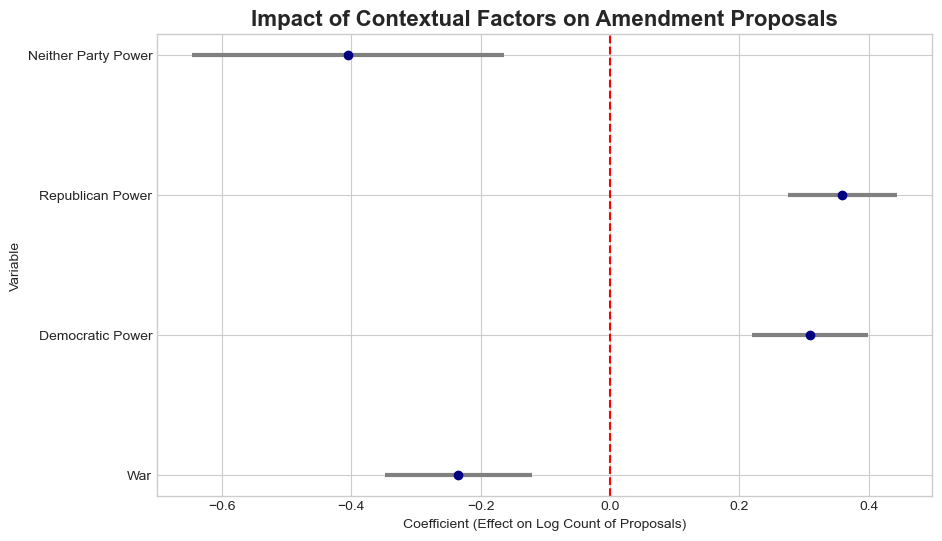

In [163]:
coefficients = {
    'War': -0.2346,
    'Democratic Power': 0.3093,
    'Republican Power': 0.3592,
    'Neither Party Power': -0.4048
}
# Standard errors from summary output
std_errors = {
    'War': 0.058,
    'Democratic Power': 0.046,
    'Republican Power': 0.043,
    'Neither Party Power': 0.123
}

coef_df = pd.DataFrame({
    'variable': list(coefficients.keys()),
    'coef': list(coefficients.values()),
    'std_err': list(std_errors.values())
})

# Calculate 95% confidence intervals (z-score for 95% is approx. 1.96)
coef_df['ci_lower'] = coef_df['coef'] - 1.96 * coef_df['std_err']
coef_df['ci_upper'] = coef_df['coef'] + 1.96 * coef_df['std_err']
coef_df['error'] = coef_df['coef'] - coef_df['ci_lower']

# Plot the coefficients
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(y=coef_df['variable'], x=coef_df['coef'], xerr=coef_df['error'],
            fmt='o', color='navy', ecolor='gray', elinewidth=3, capsize=0)

# Add a vertical line at zero to indicate no effect
ax.axvline(x=0, color='red', linestyle='--')

# Final Touches
ax.set_title('Impact of Contextual Factors on Amendment Proposals', fontsize=16, fontweight='bold')
ax.set_xlabel('Coefficient (Effect on Log Count of Proposals)')
ax.set_ylabel('Variable')
plt.show()

This coefficient plot shows us the results of the linear regression analysis. The red dotted line is essentially a baseline that says "no effect"; if a horizontal factor had zero impact, their blue dot would be on this line. Dots to the right have positive effect, meaning an increase in the # of proposed amendments. To the left means a decrease.

The figure itself tells us that political party significantly matters. When a single party has power (either Republican or Democratic), there is a significant increase in the # of proposed amendments. When there are neither, there is a decrease. The figure also indicates that, during wartime, proposed amendments decrease as the nation is focused on foreign affairs.

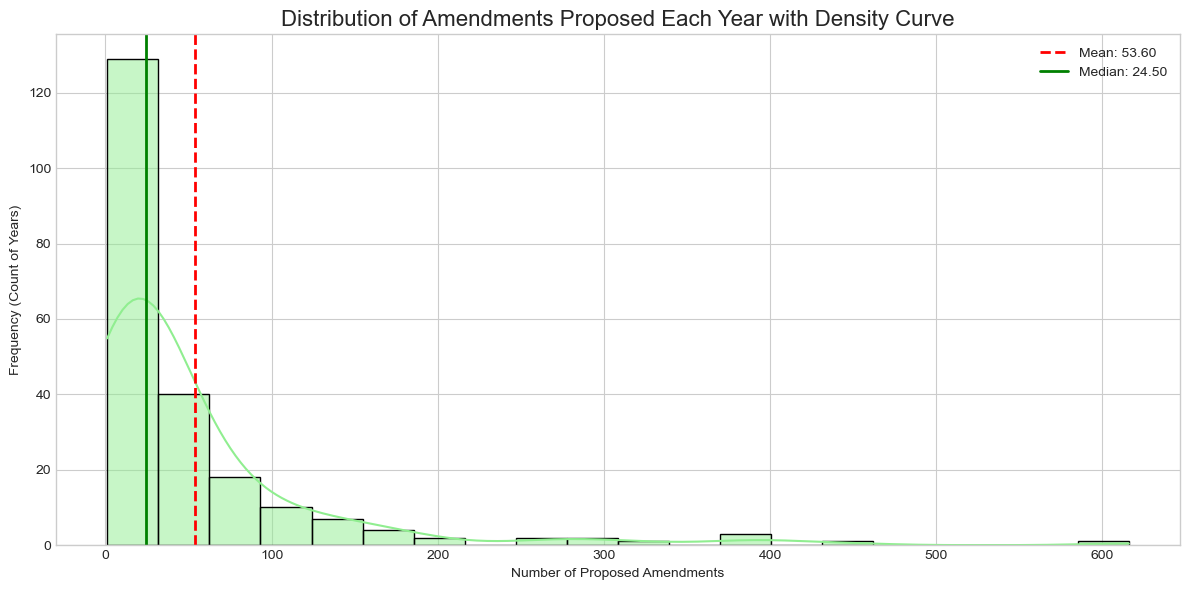

In [164]:
plt.figure(figsize=(12, 6))

sns.histplot(yearly_counts['count'], bins=20, color='lightgreen', edgecolor='black', kde=True)

# Calculate and plot the mean and median
mean_val = yearly_counts['count'].mean()
median_val = yearly_counts['count'].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

plt.title('Distribution of Amendments Proposed Each Year with Density Curve', fontsize=16)
plt.xlabel('Number of Proposed Amendments')
plt.ylabel('Frequency (Count of Years)')
plt.legend()
plt.tight_layout()
plt.show()

Green line is the median, and the red dotted line is the mean; data is right-skewed which means that there are some yeaes with a high number of amendment proposals that skews the average up.